In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import torchvision
from torchvision import transforms

from utils import *
from learner import *
from vae import *

In [2]:
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader, test_dataloader, class_names = dataloader(train_dataset, test_dataset, BATCH_SIZE)

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reconstructions(model, data, num_samples=10):
    with torch.inference_mode():
        recon_batch, _, _ = model(data.view(-1, 784))
        recon_batch = recon_batch.cpu()

    # Plot original images
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(data[i].cpu().view(28, 28).numpy(), cmap='gray')
        plt.title('Original')
        plt.axis('off')

    # Plot reconstructed images
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(recon_batch[i].view(28, 28).numpy(), cmap='gray')
        plt.title('New')
        plt.axis('off')

    plt.show()


In [5]:
ic, hc, lc = 784, 400, 20
lr = 1e-3
vae = VAE(ic, hc, lc)
loss_fn = vae_loss
epochs = 10
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader))

In [6]:
data, _ = next(iter(test_dataloader))

In [7]:
class VAE_Learner(Learner):
    def _update_results(self):
        self.loss_metric.update(self.loss)

    def _run_batch(self):
        self.X_new, self.mu, self.lv = self.model(self.X.view(-1, 784))
        self.loss = self.loss_fn(self.X_new, self.X, self.mu, self.lv)
        self._update_results()
        if self.training:
            self.optimizer.zero_grad()
            self.loss.backward()
            self.optimizer.step()

    def _run_epoch(self, train=True):
        self.training = train
        self.dl = self.train_dataloader if self.training else self.test_dataloader
        for self.X, _ in self.dl:
            self.X = self.X.to(self.device).view(-1, 784)
            self._run_batch()
   

In [8]:
vae_learner = VAE_Learner(model=vae, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, scheduler=schedular, device=device)

In [9]:
def train():
    vae_learner.fit(epochs=10, test=False)
    for batch, (data, _) in enumerate(test_dataloader):
        plot_reconstructions(vae, data.to(device))
        if batch == 5:
            break

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch	Mode	Loss	Accuracy


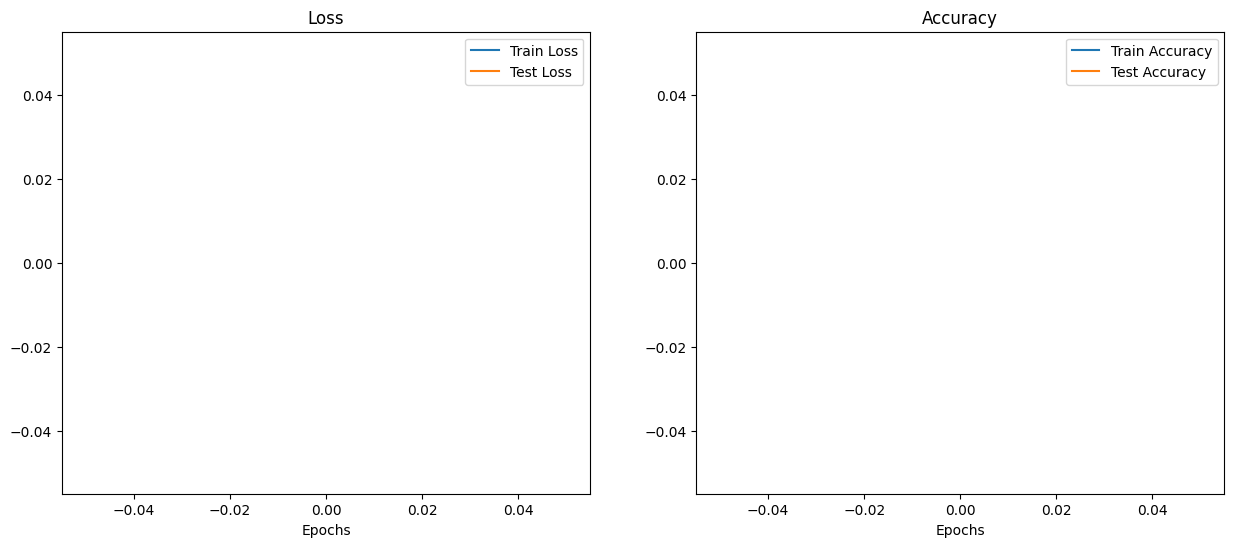

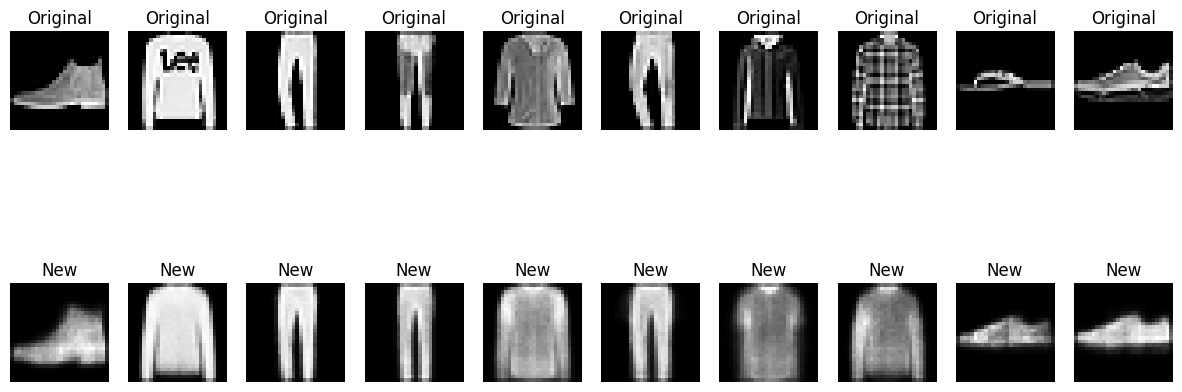

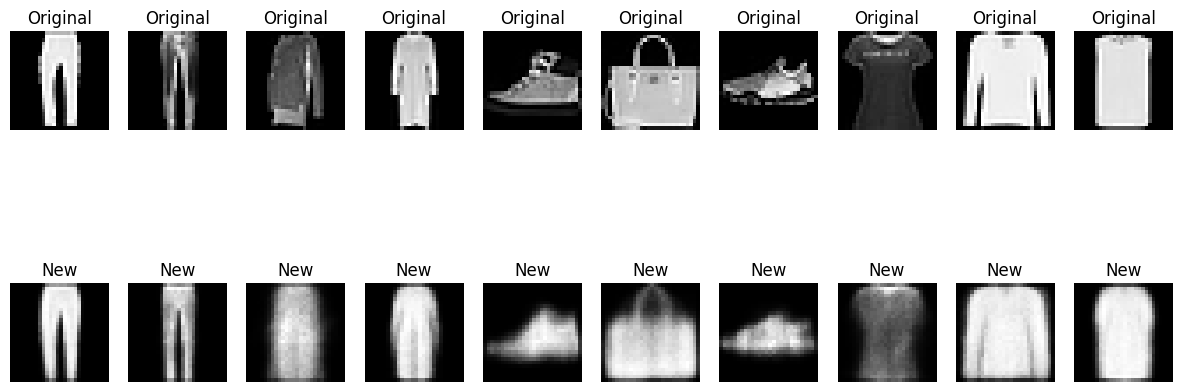

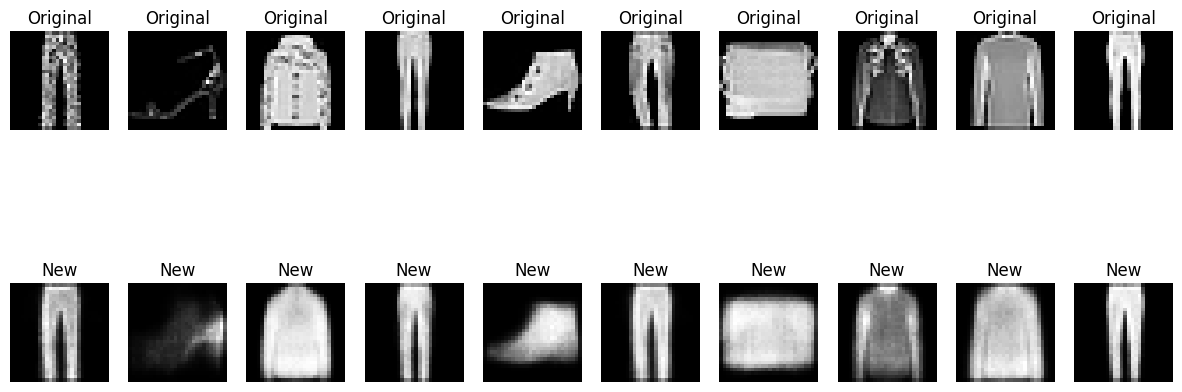

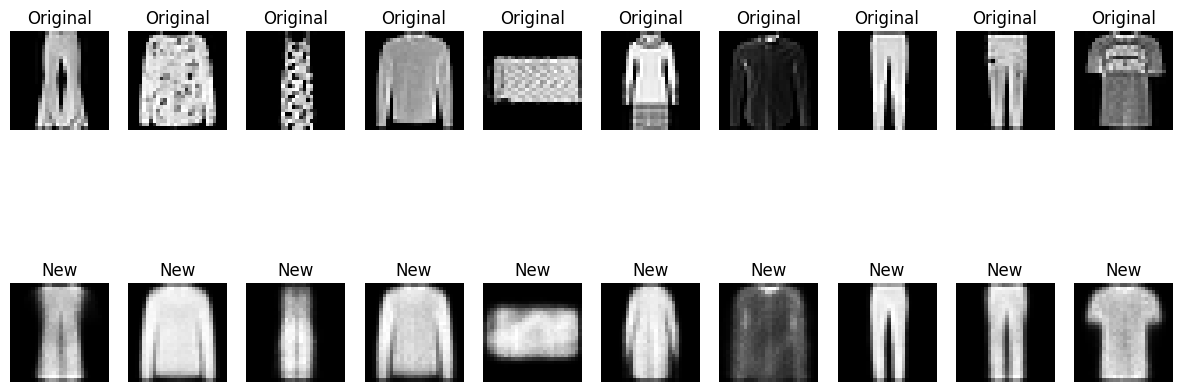

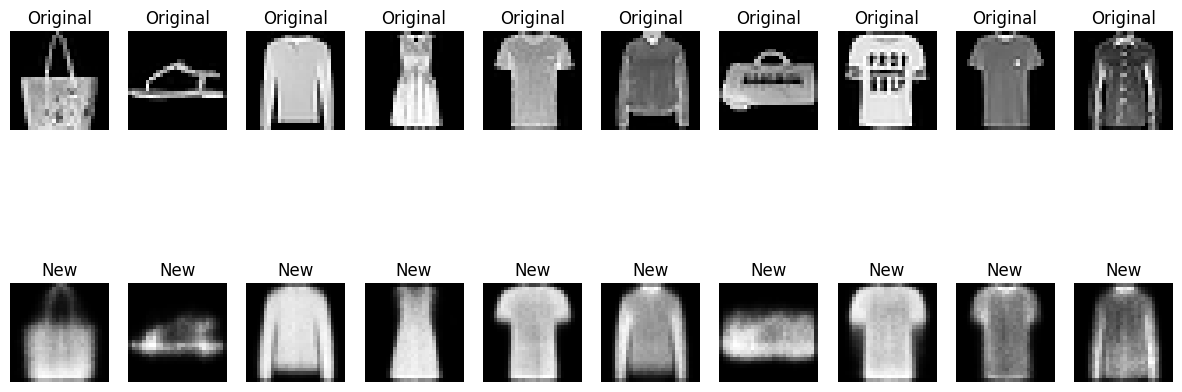

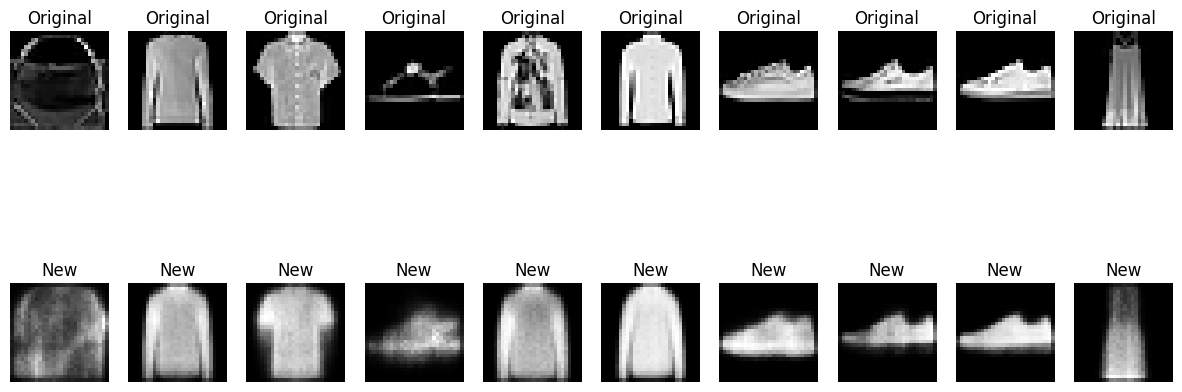

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch	Mode	Loss	Accuracy


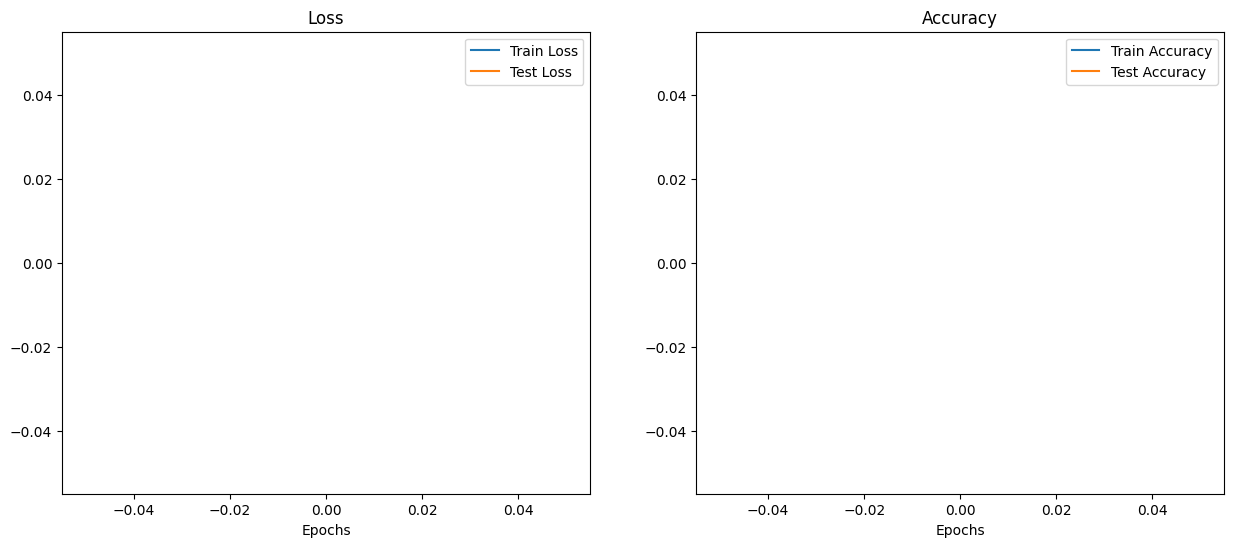

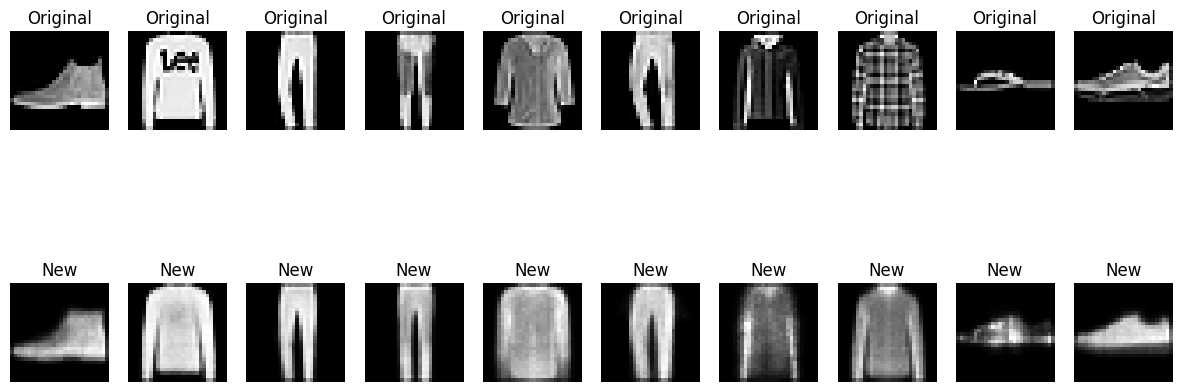

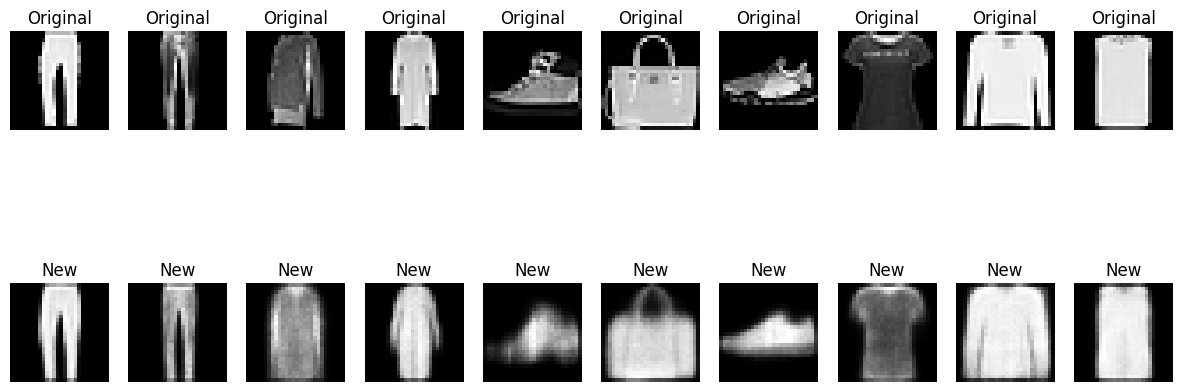

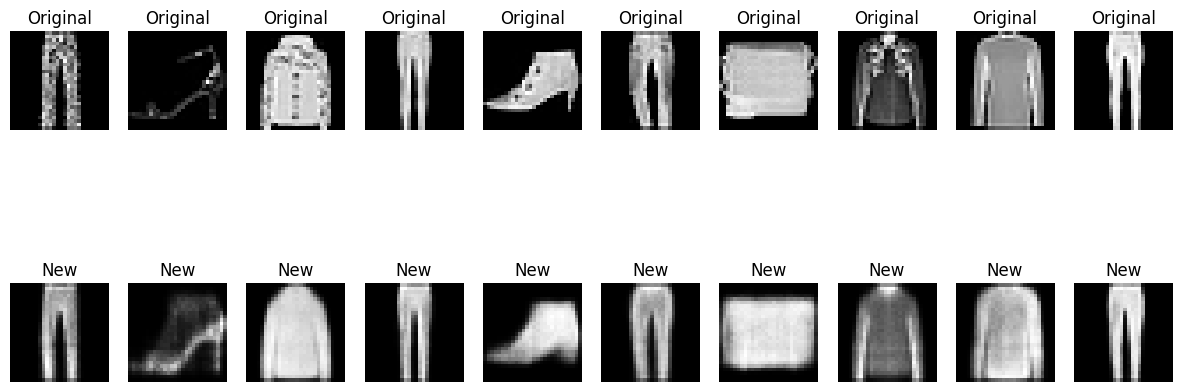

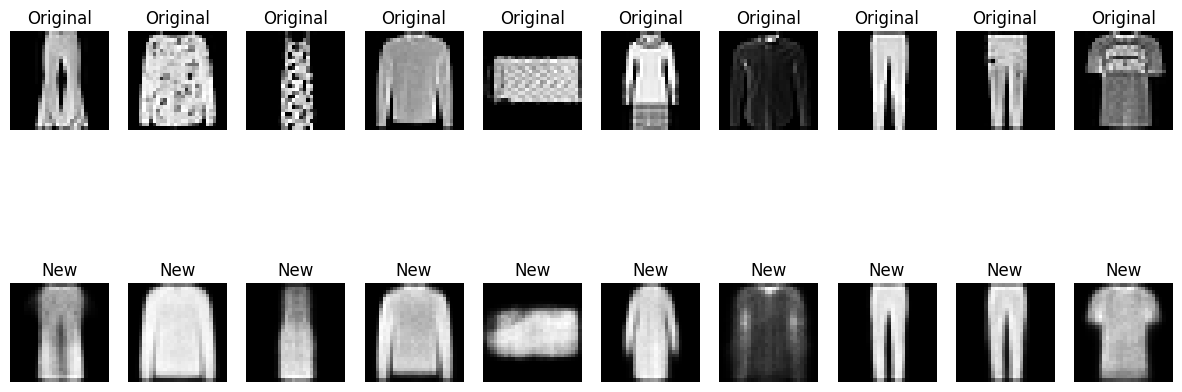

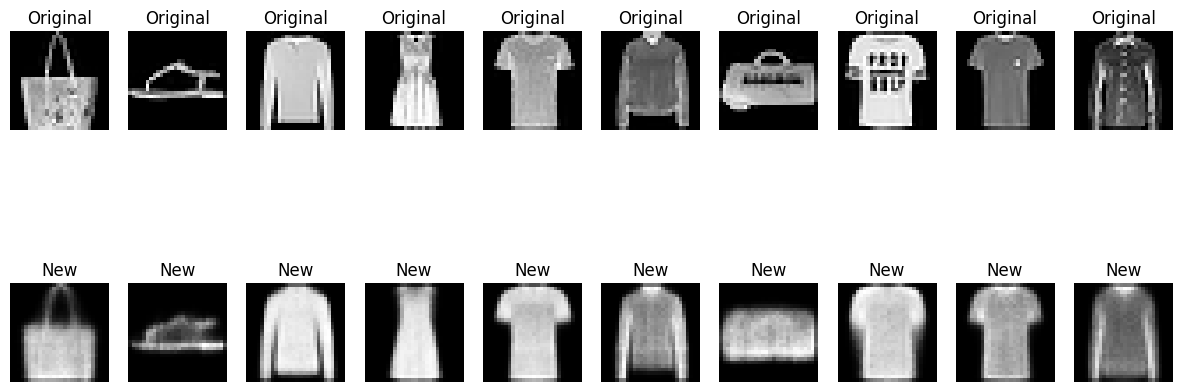

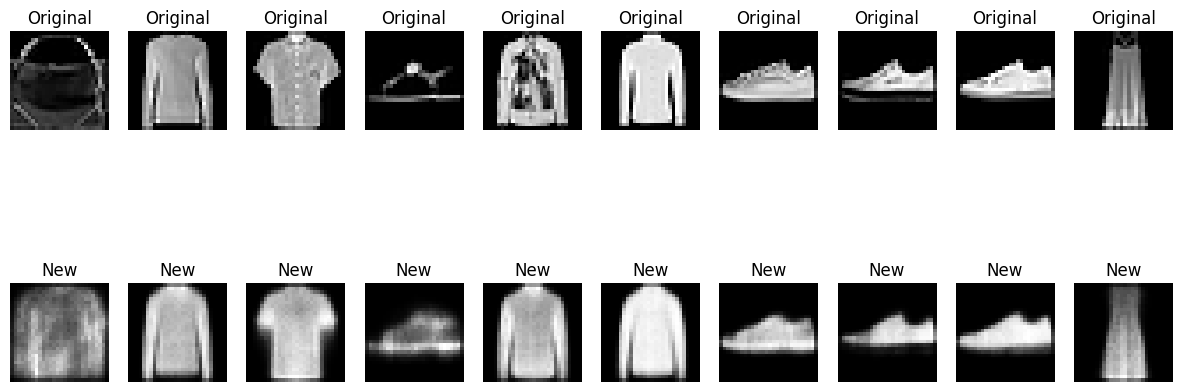

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch	Mode	Loss	Accuracy


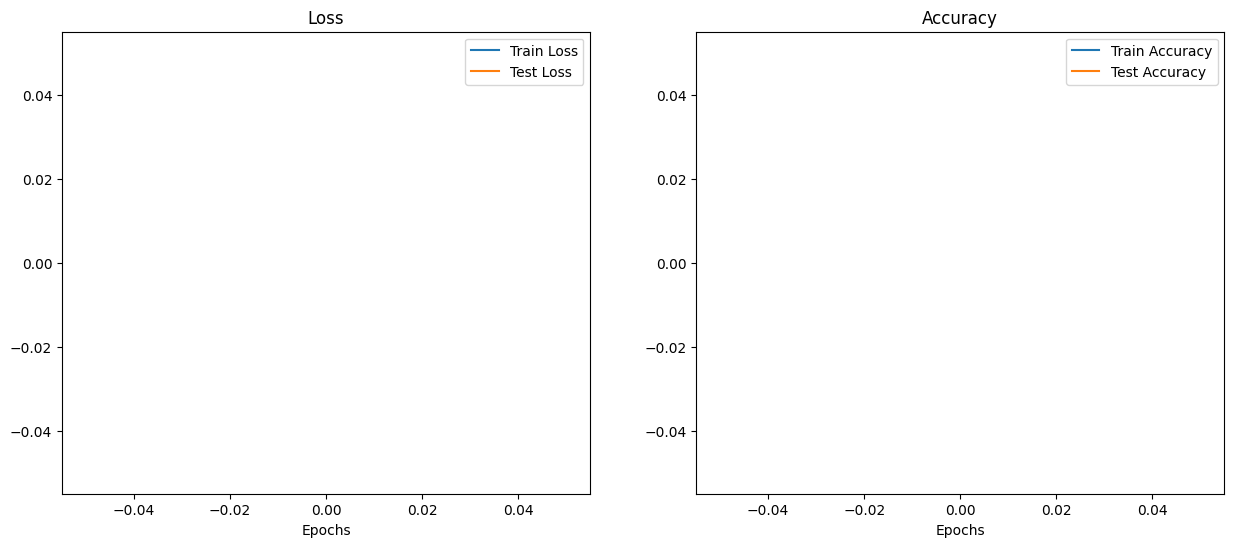

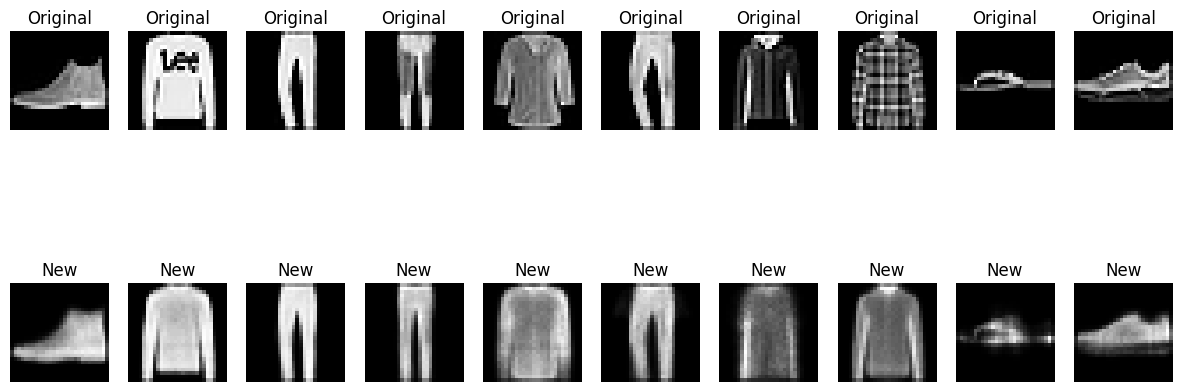

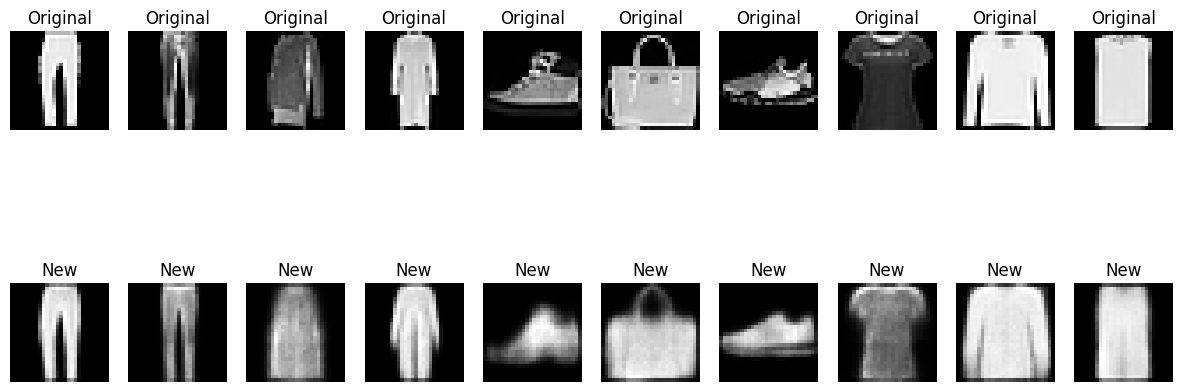

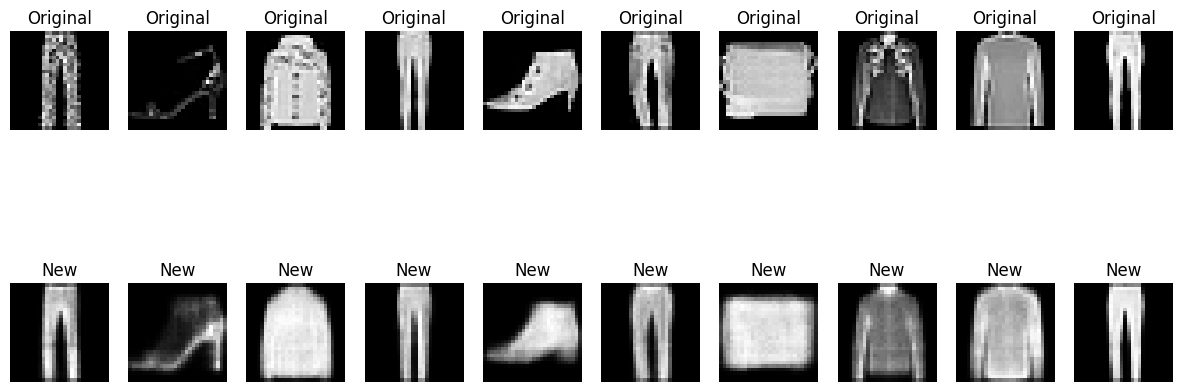

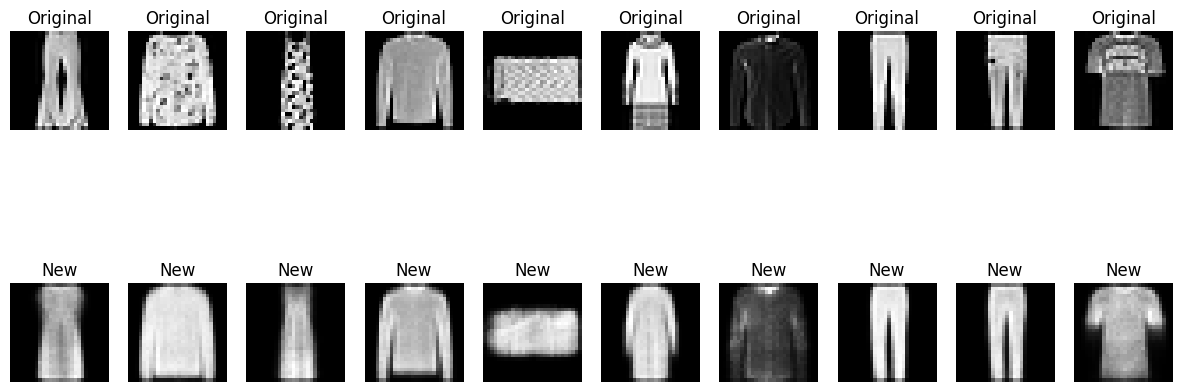

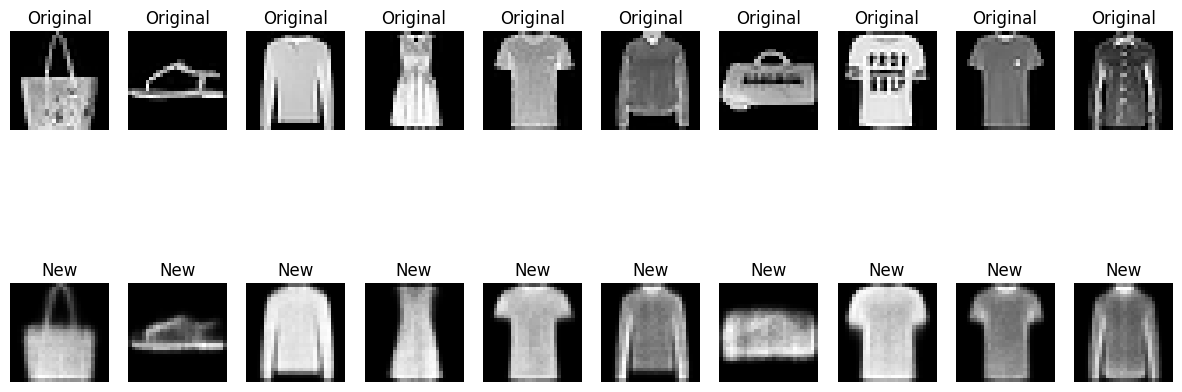

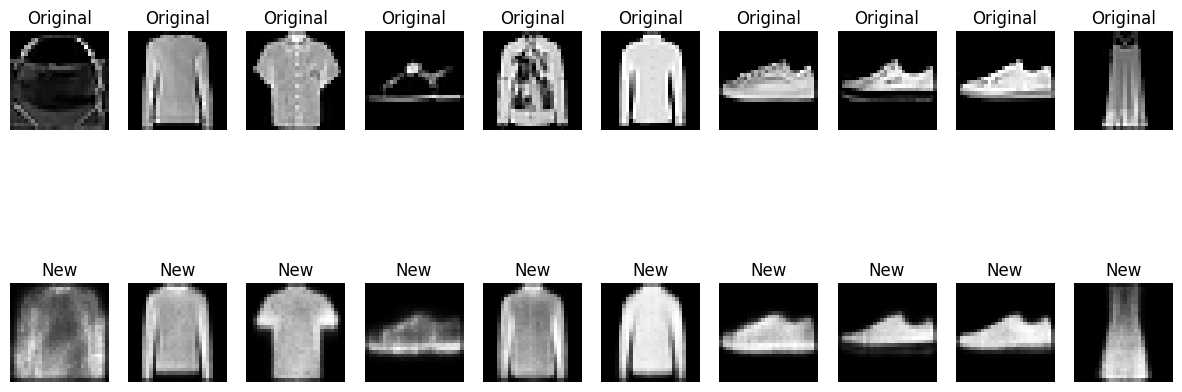

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch	Mode	Loss	Accuracy


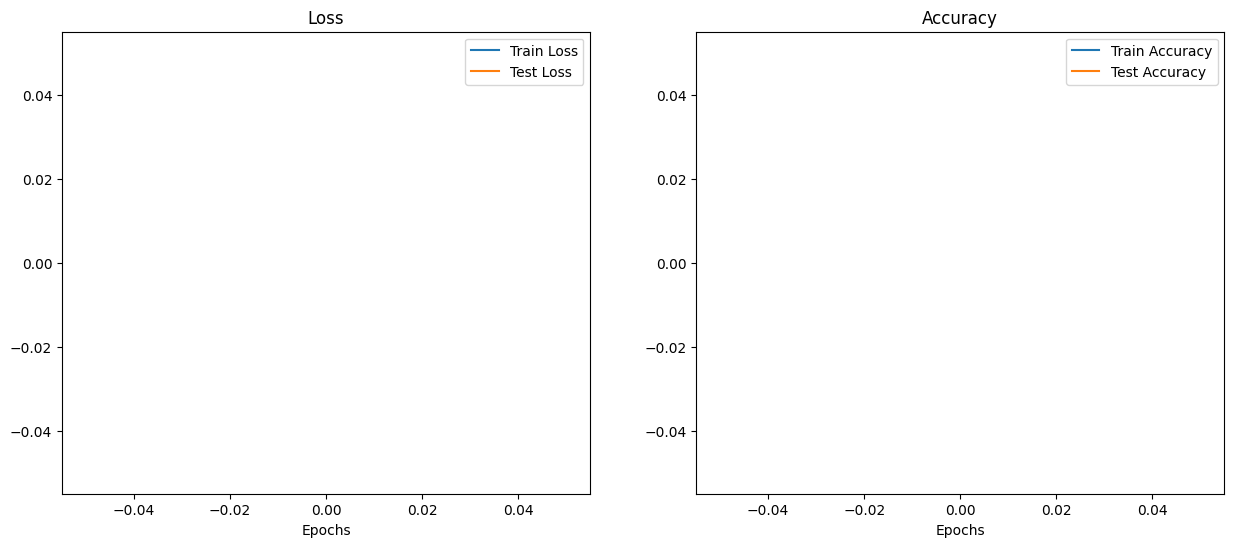

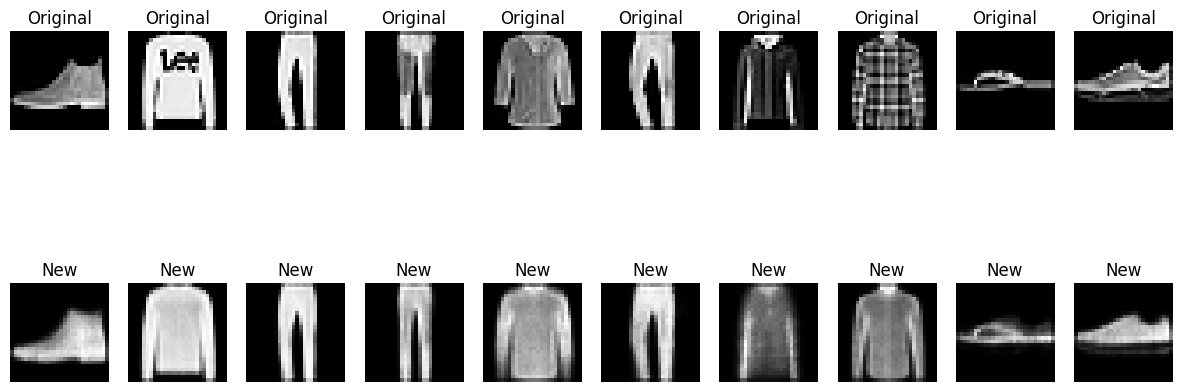

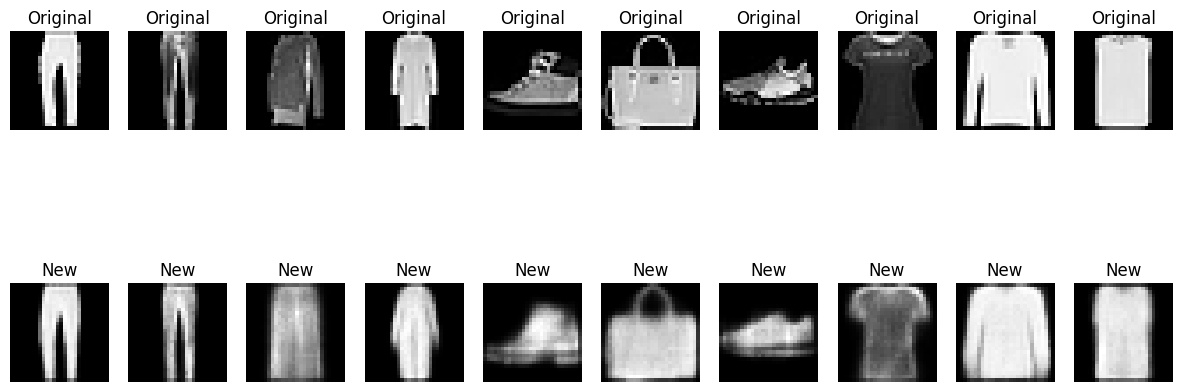

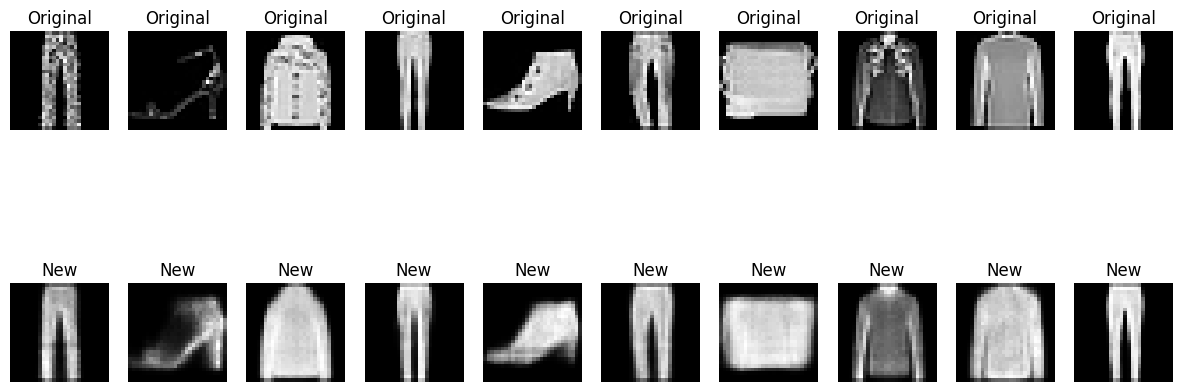

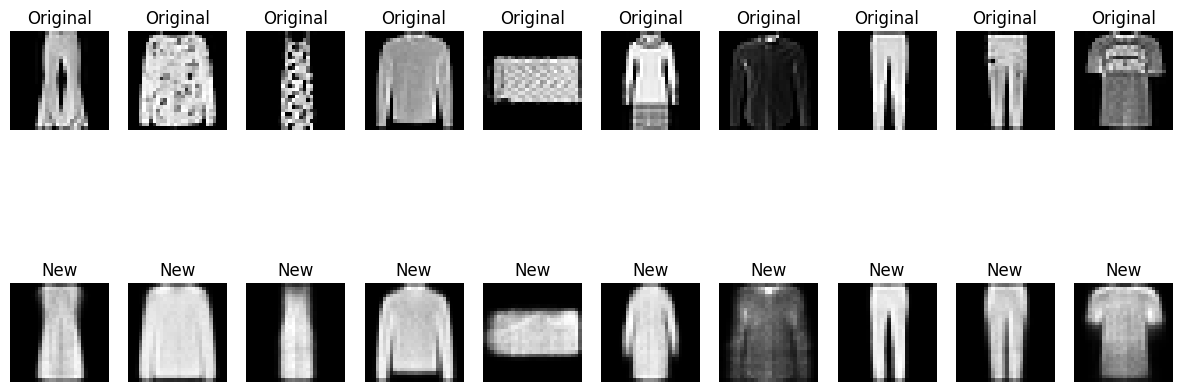

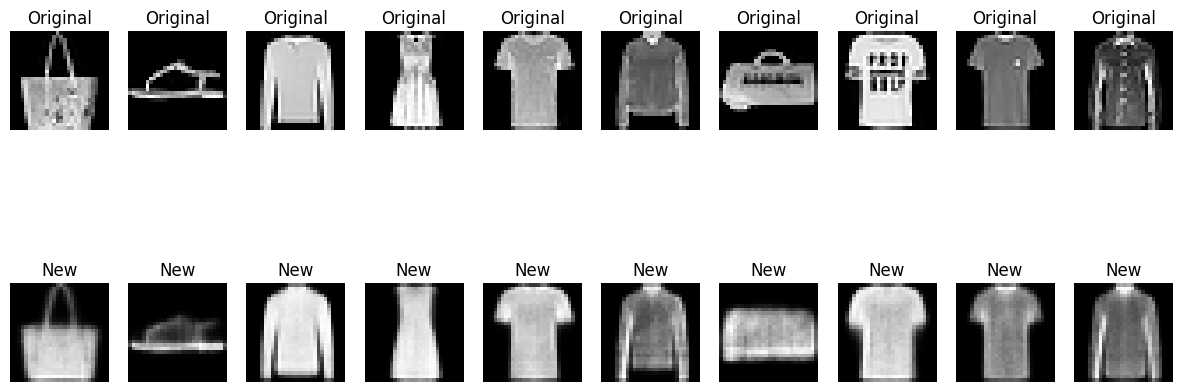

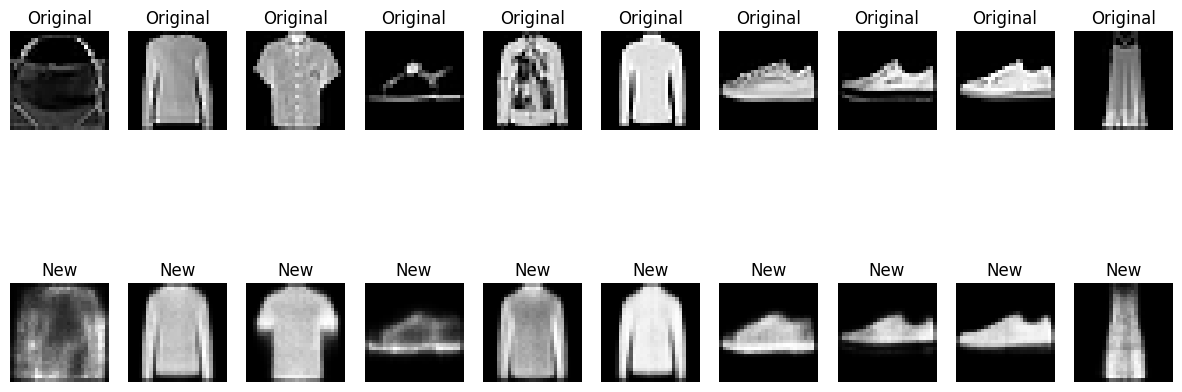

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch	Mode	Loss	Accuracy


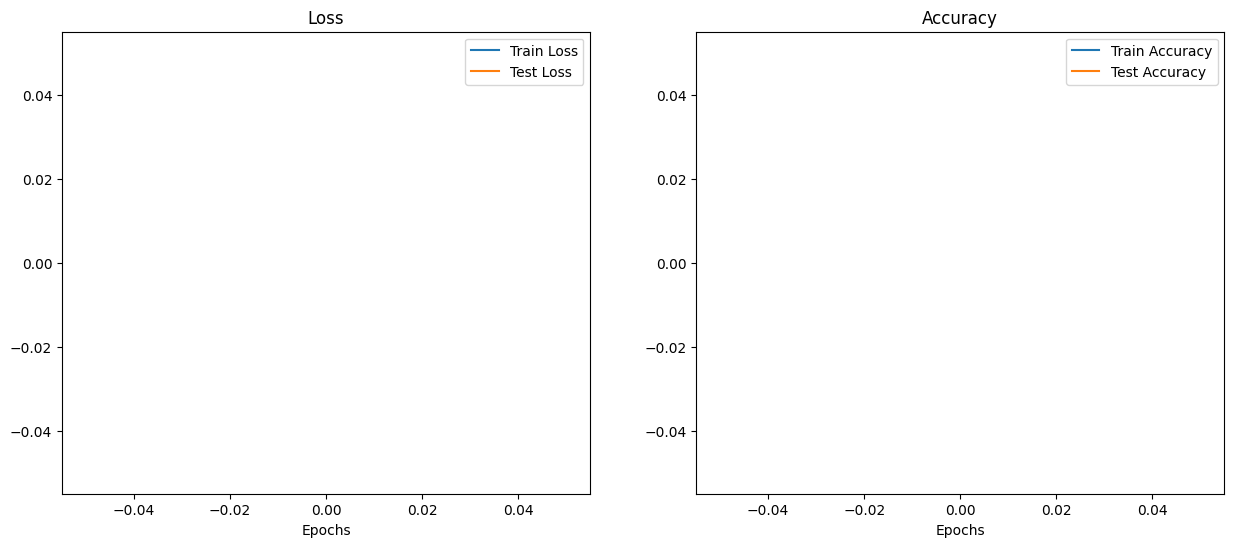

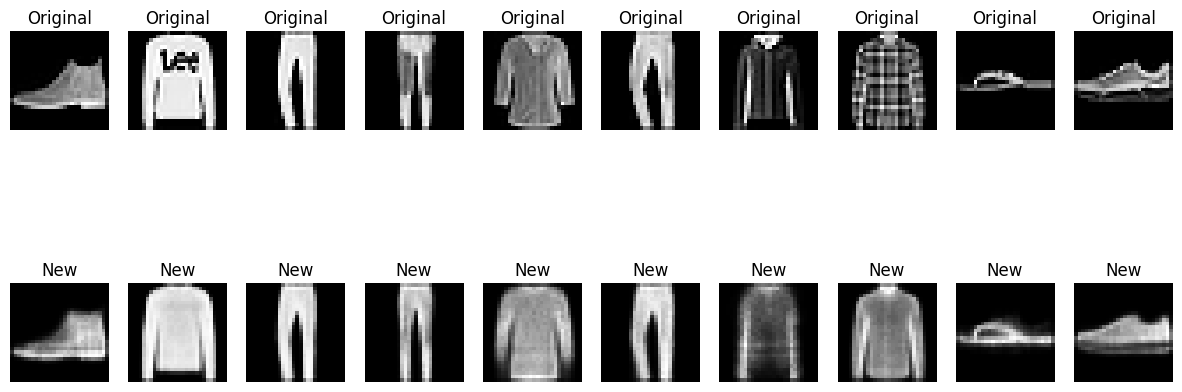

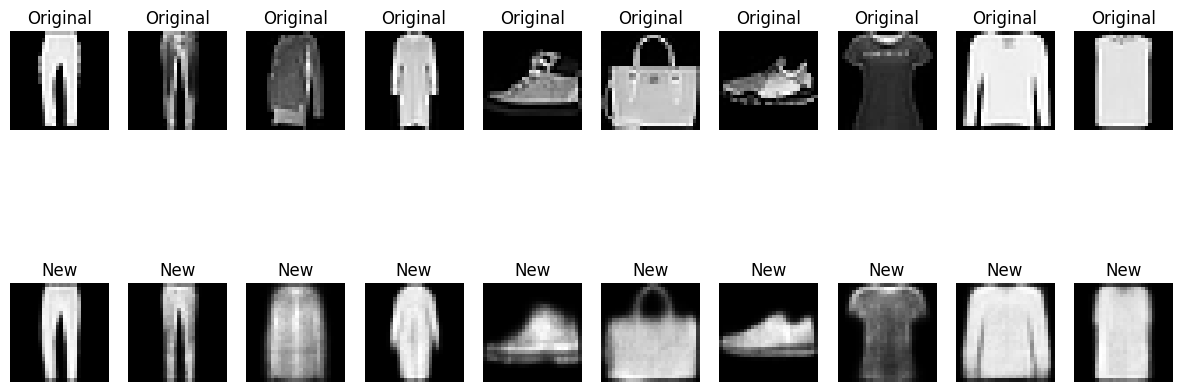

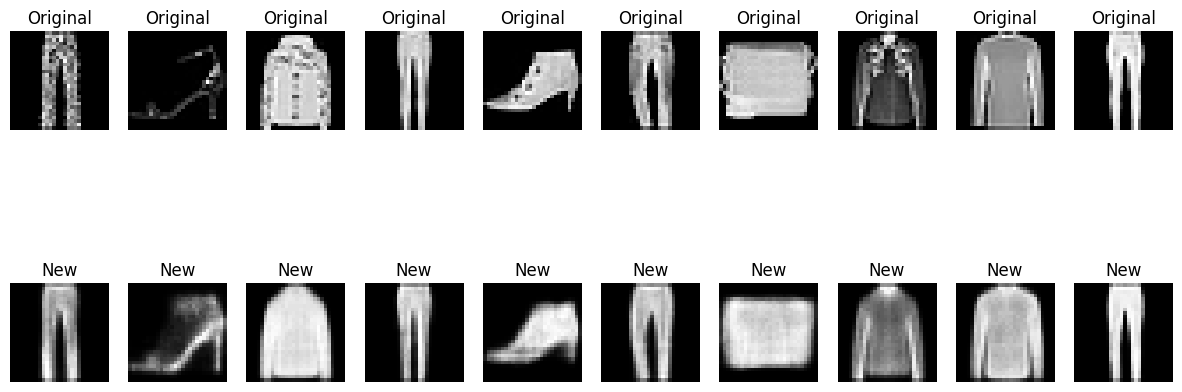

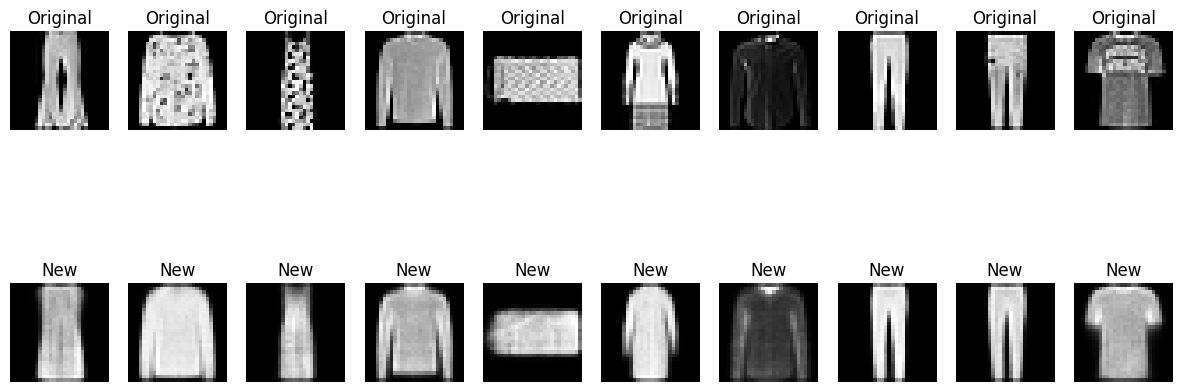

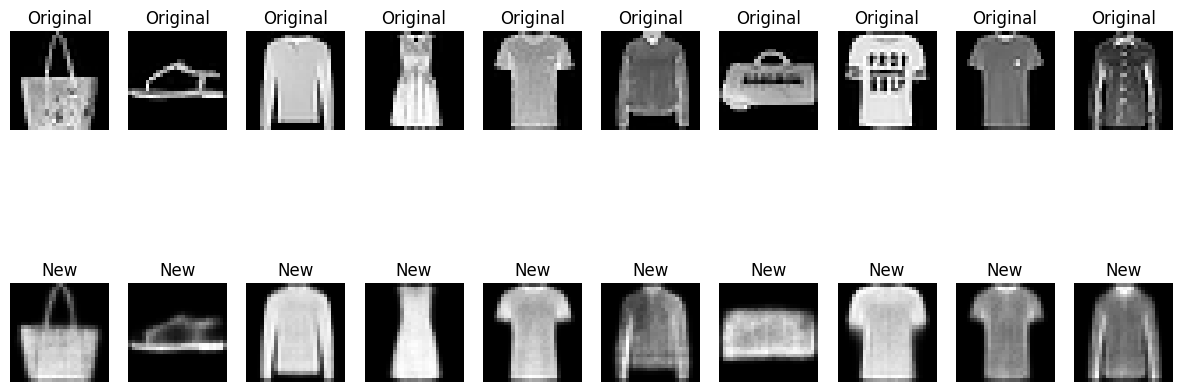

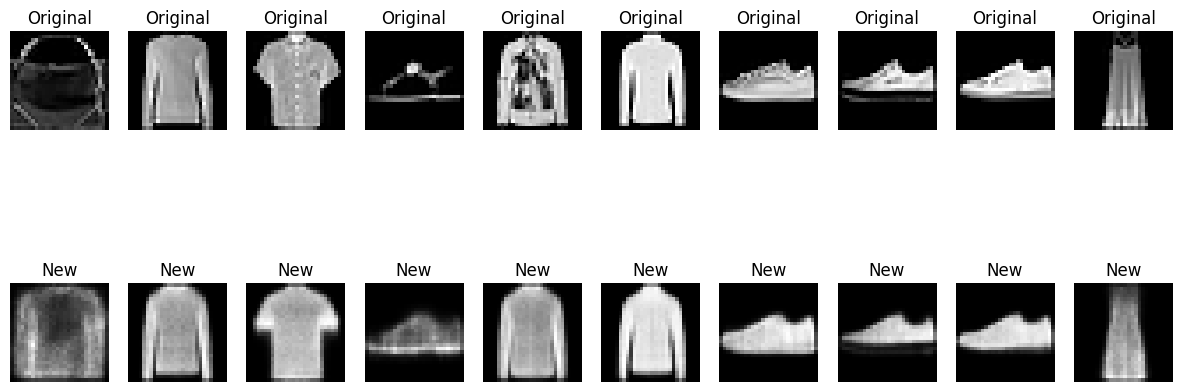

In [10]:
for _ in range(5): train()